# Shopee - Price Match Guarantee

As an example of Vektonn usage for product matching task based on the products' images we will use data from [Shopee Kaggle competiton](https://www.kaggle.com/c/shopee-product-matching/data). We need to make an embedding for each image in the train set; part of it, let's say 100, we will put aside as holdout data, which we're gonna use to make queries to Vektonn.

## Install necessary dependencies

In [1]:
! pip install --upgrade matplotlib opencv-python pandas torch torchvision vektonn

from IPython.display import clear_output
clear_output()

In [2]:
! pip list | grep vektonn

vektonn                0.5.2               


In [3]:
import cv2
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

## Get dataset and make some EDA

Dataset - https://www.kaggle.com/c/shopee-product-matching/data

First we need to download it and put into `.data` directory. One can use `download-dataset.sh` script located in the current directory.

Then we can read it:

In [4]:
img_path = '.data/train_images/'
df = pd.read_csv('.data/train.csv')
print(df.shape)

(34250, 5)


You could see the full description of the data on the competition page, but for now we need only 3 columns - image (to load the images), title (to understand what exactly is presented on the image) and label group (to check if images are related to the same product)

In [5]:
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


Let's check the total number of unique labels

In [6]:
df.label_group.nunique()

11014

Major ones by quantity of products

In [7]:
df.label_group.value_counts().head(15)

994676122     51
1163569239    51
1141798720    51
159351600     51
562358068     51
3113678103    51
3627744656    51
3206118280    49
1733221456    46
1166650192    46
1091404026    45
3489985175    41
1237550763    37
1746655739    36
452508504     35
Name: label_group, dtype: int64

And some images from the same label group

In [8]:
def plot_imgs(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

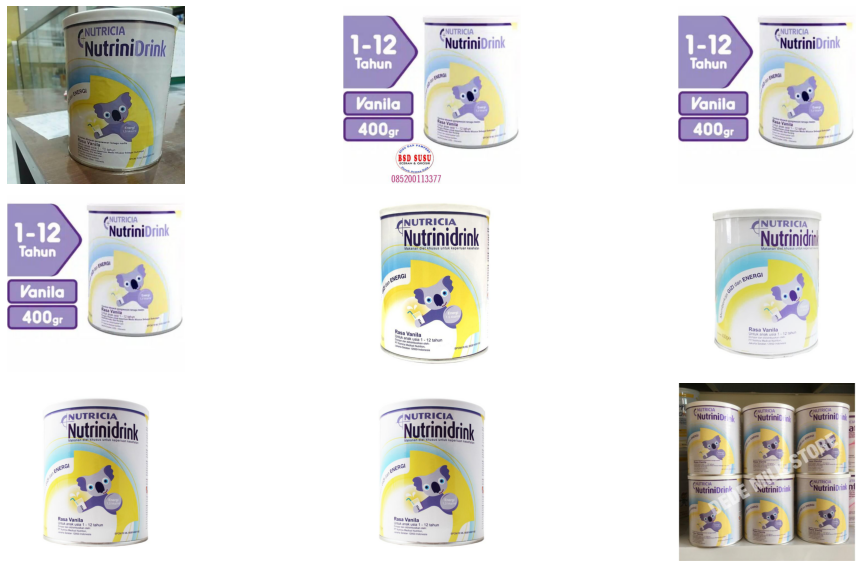

In [9]:
plot_imgs([(img_path + img) for img in list(df[df.label_group==899136538].image)], 3, 3)

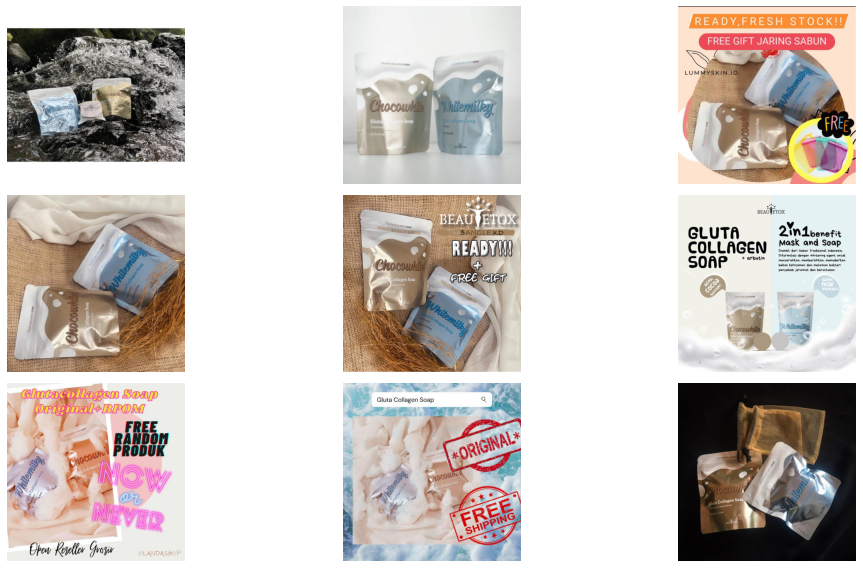

In [10]:
plot_imgs([(img_path + img) for img in list(df[df.label_group==159351600].image)], 3, 3)

## Embeddings
Now let's prepare some embeddings using pretrained MobileNet from torchvision for simplicity (you can use any model you want, the main goal now is to obtain vector representations of the images)

In [11]:
model = models.mobilenet_v2(pretrained=True)

In [12]:
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

In [13]:
device = torch.device('cpu')
model.to(device)
model.eval();

In [14]:
BATCH_SIZE = 16
embeddings = []

for i in tqdm(range(0, df.shape[0], BATCH_SIZE)):
    image_names = list(df.image[i:i+BATCH_SIZE])
    images = []
    for name in image_names:
        images.append(Image.open(img_path + name).convert('RGB'))
    batch = torch.stack([data_transform(image) for image in images])
    inputs = batch.to(device)
    
    with torch.set_grad_enabled(False):
        output = model(inputs)
        embeddings.extend(output)

100%|█████| 2141/2141 [18:41<00:00,  1.91it/s]


In [15]:
np_embeddings = [e.cpu().numpy() for e in embeddings]
array = np.array(np_embeddings)

In [16]:
df_embeddings = pd.DataFrame(array)
print(df_embeddings.shape)

(34250, 1000)


Let's take a sample from train part for queries and then remove it from dataset

In [17]:
queries_subset = df_embeddings.sample(n=50, random_state=42).reset_index(drop=True)
queries_subset_meta = df.sample(n=50, random_state=42).reset_index(drop=True)

In [18]:
df_embeddings = df_embeddings.drop(queries_subset.index).reset_index(drop=True)
print(df_embeddings.shape)
df = df.drop(queries_subset_meta.index).reset_index(drop=True)
print(df.shape)

(34200, 1000)
(34200, 5)


## Use Vektonn

### Setup data source and index schema

Define Vektonn data source:

In [19]:
%%bash

data_source_schema_dir=../../docker/config/data-sources/Examples.Shopee
mkdir -p $data_source_schema_dir

cat <<EOF > "$data_source_schema_dir/1.0.yaml"
vectorDimension: 1000
vectorsAreSparse: false
attributeValueTypes:
  posting_id: String
  image: String
  title: String
  label_group: int64
permanentAttributes: ["posting_id"]
EOF

Define Vektonn index:

In [20]:
%%bash

index_schema_dir=../../docker/config/indices/Examples.Shopee
mkdir -p $index_schema_dir

cat <<EOF > "$index_schema_dir/1.0.yaml"
dataSourceId:
  name: Examples.Shopee
  version: 1.0
indexAlgorithm: FaissIndex.Flat.L2
idAttributes: ["posting_id"]
shardsById:
  SingleShard: {}
EOF

### Start Vektonn services

In [21]:
! ../../docker/run-vektonn.sh Examples.Shopee
clear_output()

Init Vektonn API client:

In [22]:
from vektonn import Vektonn

vektonn_client = Vektonn('http://localhost:8081')

### Upload data points

Upload embeddings and corresponding attributes to Vektonn:

In [23]:
from vektonn.dtos import InputDataPointDto, AttributeDto, AttributeValueDto, VectorDto

input_data_points = []
for idx, row in df.iterrows():
    input_data_points.append(InputDataPointDto(
        attributes=[
            AttributeDto(key='posting_id', value=AttributeValueDto(string=row.posting_id)),
            AttributeDto(key='image', value=AttributeValueDto(string=row.image)),
            AttributeDto(key='title', value=AttributeValueDto(string=row.title)),
            AttributeDto(key='label_group', value=AttributeValueDto(int64=row.label_group)),
        ],
        vector=VectorDto(is_sparse=False, coordinates=df_embeddings.iloc[idx].tolist()),
    ))
print(len(input_data_points))

34200


In [24]:
data_source_name = 'Examples.Shopee'
data_source_version = '1.0'

try:
    vektonn_client.upload(data_source_name, data_source_version, input_data_points)
    print(f'Successfully uploaded {len(input_data_points)} data points')
except BaseException as err:
    print(f'Unexpected error: {repr(err)}')

Successfully uploaded 34200 data points


### Search for similiar images

Let's send a test query and see what we're gonna receive. So, for example, the query image is:

5c138e8fccfc7bc6d6e364bd31eb6657.jpg


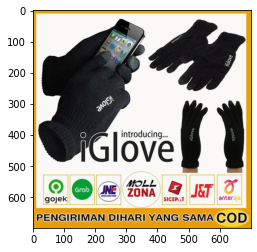

In [25]:
query_image = queries_subset_meta.image[4]
print(query_image)

plt.imshow(Image.open(img_path + query_image).convert('RGB'));

And query for it (should return k = 10 nearest neighbors):

In [26]:
from vektonn.dtos import SearchQueryDto, VectorDto

index_name = 'Examples.Shopee'
index_version = '1.0'

k = 10
search_query = SearchQueryDto(k=k, query_vectors=[
    VectorDto(is_sparse=False, coordinates=queries_subset.iloc[[4]].values[0].tolist()),
])

try:
    search_results = vektonn_client.search(index_name, index_version, search_query)
    display(search_results[0].nearest_data_points[0].attributes)
except BaseException as err:
    print(f'Unexpected error: {repr(err)}')

[AttributeDto(key='posting_id', value=AttributeValueDto(string='train_2554398684', guid=None, bool=None, int64=None, float64=None, date_time=None)),
 AttributeDto(key='image', value=AttributeValueDto(string='5c138e8fccfc7bc6d6e364bd31eb6657.jpg', guid=None, bool=None, int64=None, float64=None, date_time=None)),
 AttributeDto(key='label_group', value=AttributeValueDto(string=None, guid=None, bool=None, int64=66247839, float64=None, date_time=None)),
 AttributeDto(key='title', value=AttributeValueDto(string='SARUNG TANGAN IGLOVE TOUCH SCREEN HP ANDROID GOJEK GRAB', guid=None, bool=None, int64=None, float64=None, date_time=None))]

In [27]:
result_imgs = []
for data_point in search_results[0].nearest_data_points:
    attributes = {x.key : x.value for x in data_point.attributes}
    result_imgs.append(attributes['image'].string)
    
display(result_imgs)

['5c138e8fccfc7bc6d6e364bd31eb6657.jpg',
 'a224fb75dc16f600958e1faf9d6d80b8.jpg',
 '1d5383e8d29fd9b1013e46ffce75c47c.jpg',
 '5e10447cd06457d087373cf9b53da309.jpg',
 '5e10447cd06457d087373cf9b53da309.jpg',
 '304ea8a843015b6b156c7f35af79a952.jpg',
 '671d0d4605652412e009c6e6909eeeda.jpg',
 '2d654b341ead327b35ff1fca042c64a3.jpg',
 'd2c75fe3792ec3cbefd7ea9f0670a72d.jpg',
 '3dfa371694073047d8bb58a5bad8738d.jpg']

Let's see what we got as a result of our test query. Note that the first image is the duplicate of the query image itself (there are a lot of duplicates in the whole train dataset as it was composed using images of different products from different online marketplaces).

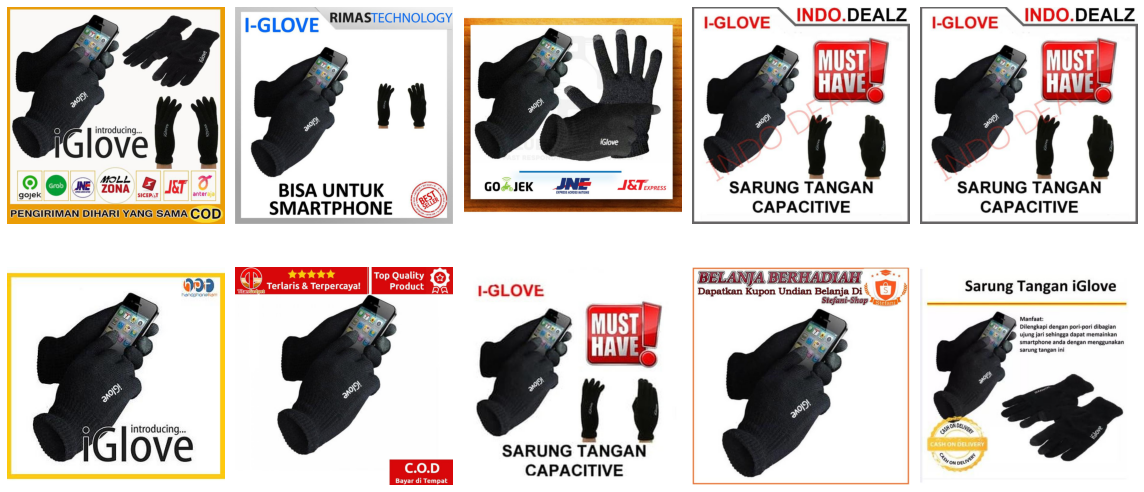

In [28]:
plot_imgs([(img_path + img) for img in result_imgs], 2, k//2)